In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.optimizers import Adam
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import datetime as dt

In [2]:
#Load dataset into a pandas dataframe

# data = pd.read_csv("../data/Cleaned data/data.csv")
data = pd.read_csv("data.csv") 
data.dropna(inplace = True)
data.head()

,YEAR,MONTH,DAY,HUMIDITY,WINDSPEED,DATE,TOTALDEMAND,HOLIDAY,MIN,MAX,SOLAR,TEMPAVE,RRP,FORECASTDEMAND,OUTPUT,MONTHDATE,WEEKDAY,WEEKEND
0,2016,1,1,0.656341,15.902439,2016-01-01,6853.633437,2.0,15.3,28.6,32.2,21.95,38.472917,6665.366167,23.465,01-2016,4,0
1,2016,1,2,0.656341,15.902439,2016-01-02,6727.613958,0.0,15.9,26.1,21.7,21.00,36.907292,6236.849955,23.465,01-2016,5,1
2,2016,1,3,0.688837,14.488372,2016-01-03,6616.406076,0.0,17.5,25.6,10.3,21.55,31.997083,6551.924748,23.465,01-2016,6,1
3,2016,1,4,0.679545,22.477273,2016-01-04,7367.750278,0.0,18.2,23.6,6.4,20.90,33.424583,6729.993123,23.465,01-2016,0,0
4,2016,1,5,0.768837,22.581395,2016-01-05,7462.242014,0.0,17.6,20.5,4.4,19.05,33.053958,7333.898202,23.465,01-2016,1,0


In [3]:
df = data.drop(['MIN','MAX', 'MONTHDATE','WEEKEND'], axis=1)
df.head()

#print(df.isna().sum())
# Check number of rows in df before join operation
print("Number of rows in df before join operation:", df.shape[0])

Number of rows in df before join operation: 2325


In [4]:
# Onehot Encoding for categorial data (Weekday)

# Select the "WEEKDAY" column and create a new dataframe
weekday_df = df[['WEEKDAY']].reset_index(drop=True)

# Create a one-hot encoder object
encoder = OneHotEncoder(categories='auto')

# Fit and transform the weekday data
weekday_encoded = encoder.fit_transform(df[['WEEKDAY']]).toarray()

# Create a new dataframe with the encoded weekday data
weekday_df_encoded = pd.DataFrame(weekday_encoded, columns=['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN']).reset_index(drop=True)

#Drop weekday column
df = df.drop(['WEEKDAY'], axis=1)

# Concatenate the original dataframe with the encoded weekday dataframe
df = pd.concat([df.reset_index(drop=True), weekday_df_encoded], axis=1)

df.head()

,YEAR,MONTH,DAY,HUMIDITY,WINDSPEED,DATE,TOTALDEMAND,HOLIDAY,SOLAR,TEMPAVE,RRP,FORECASTDEMAND,OUTPUT,MON,TUE,WED,THU,FRI,SAT,SUN
0,2016,1,1,0.656341,15.902439,2016-01-01,6853.633437,2.0,32.2,21.95,38.472917,6665.366167,23.465,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2016,1,2,0.656341,15.902439,2016-01-02,6727.613958,0.0,21.7,21.00,36.907292,6236.849955,23.465,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2016,1,3,0.688837,14.488372,2016-01-03,6616.406076,0.0,10.3,21.55,31.997083,6551.924748,23.465,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2016,1,4,0.679545,22.477273,2016-01-04,7367.750278,0.0,6.4,20.90,33.424583,6729.993123,23.465,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2016,1,5,0.768837,22.581395,2016-01-05,7462.242014,0.0,4.4,19.05,33.053958,7333.898202,23.465,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Convert the 'date' column to a datetime object
df['DATE'] = pd.to_datetime(df['DATE'])

# Set 'DATE' as the index
df.set_index('DATE', inplace=True)

In [6]:
# Split the dataset into training and testing sets. 
train_set = np.where((df.index >= datetime(2017, 8, 1)) & (df.index < datetime(2021, 8, 1)))[0]
test_set = np.where(df.index >= datetime(2021, 8, 1))[0]

# identify response variable and predictors
X = df.drop(['TOTALDEMAND','FORECASTDEMAND'], axis=1).values
X_all = df.values[test_set] # save for plotting later
X_all_cols = list(df.columns)
y = df['TOTALDEMAND'].values


In [7]:
# Normalize the data
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler_X.fit_transform(X[train_set])
X_test_scaled = scaler_X.transform(X[test_set])

scaler_y = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler_y.fit_transform(y[train_set].reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y[test_set].reshape(-1, 1)).ravel()

print(X_test_scaled[:5])
print(X_train_scaled[:5])
print(y_test_scaled[:5])
print(y_train_scaled[:5])

[[1.         0.63636364 0.         0.45335607 0.40432429 0.
  0.2724359  0.38353765 0.23953648 0.12358105 0.         0.
  0.         0.         0.         0.         1.        ]
 [1.         0.63636364 0.03333333 0.45335607 0.40432429 1.
  0.36217949 0.21190893 0.31218315 0.12358105 1.         0.
  0.         0.         0.         0.         0.        ]
 [1.         0.63636364 0.06666667 0.55427801 0.22875414 0.
  0.39102564 0.32399299 0.2111023  0.12358105 0.         1.
  0.         0.         0.         0.         0.        ]
 [1.         0.63636364 0.1        0.49131993 0.38467382 0.
  0.40384615 0.16462347 0.33700286 0.12358105 0.         0.
  1.         0.         0.         0.         0.        ]
 [1.         0.63636364 0.13333333 0.32768625 0.56915181 0.
  0.41025641 0.24343257 0.22903169 0.12358105 0.         0.
  0.         1.         0.         0.         0.        ]]
[[0.         0.63636364 0.         0.54515261 0.48699955 0.
  0.38782051 0.18563923 0.7116133  0.10793701 0. 

In [8]:
#Reshape the data for input to the LSTM model
#(This step is fit the data to 3D tensor format for LSTM model to process the sequential data efficiently 
#and capture any temporal dependencies in the data)
#using sliding window approach to create input-output pairs with timesteps n = 1

X_train = []
y_train = []
for i in range(1, len(X_train_scaled)):
    X_train.append(X_train_scaled[i-1:i, :])
    y_train.append(X_train_scaled[i, 1])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))

X_test = []
y_test = []
for i in range(1, len(X_test_scaled)):
    X_test.append(X_test_scaled[i-1:i, :])
    y_test.append(X_test_scaled[i, 1])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_train.shape[2]))

In [9]:
# Build the LSTM model with three LSTM layers and one Dense output layer 
model = Sequential()
model.add(LSTM(units=128, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=64, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='linear'))
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='mean_squared_error', optimizer=optimizer)

In [10]:
# Training the LSTM model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
45/45 [==============================] - 4s 21ms/step - loss: 0.3385 - val_loss: 0.3267
Epoch 2/50
45/45 [==============================] - 0s 4ms/step - loss: 0.2999 - val_loss: 0.2796
Epoch 3/50
45/45 [==============================] - 0s 6ms/step - loss: 0.2489 - val_loss: 0.2150
Epoch 4/50
45/45 [==============================] - 0s 6ms/step - loss: 0.1830 - val_loss: 0.1418
Epoch 5/50
45/45 [==============================] - 0s 10ms/step - loss: 0.1203 - val_loss: 0.0989
Epoch 6/50
45/45 [==============================] - 0s 4ms/step - loss: 0.0902 - val_loss: 0.0925
Epoch 7/50
45/45 [==============================] - 0s 4ms/step - loss: 0.0820 - val_loss: 0.0866
Epoch 8/50
45/45 [==============================] - 0s 9ms/step - loss: 0.0736 - val_loss: 0.0791
Epoch 9/50
45/45 [==============================] - 0s 4ms/step - loss: 0.0666 - val_loss: 0.0696
Epoch 10/50
45/45 [==============================] - 0s 8ms/step - loss: 0.0589 - val_loss: 0.0598
Epoch 11/50
45/45

In [11]:
# Make predictions on the test set
y_pred = model.predict(X_test)

11/11 [==============================] - 0s 2ms/step


In [12]:
# Calculate MSE and R-squared

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('MSE: %.4f' % mse)
print('R-squared: %.4f' % r2)

MSE: 0.0052
R-squared: 0.9516


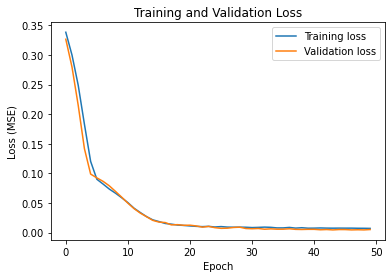

In [13]:
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import datetime as dt

# Plot training and validation loss (MSE) for each epoch
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()


Plot Accuracy

In [14]:
df_lim = pd.DataFrame(X_all).iloc[:-1,:]
df_lim.columns = X_all_cols
df_lim['YEAR'] = df_lim['YEAR'].astype(int)
df_lim['MONTH'] = df_lim['MONTH'].astype(int)
df_lim['DAY'] = df_lim['DAY'].astype(int)
df_lim.head()

,YEAR,MONTH,DAY,HUMIDITY,WINDSPEED,TOTALDEMAND,HOLIDAY,SOLAR,TEMPAVE,RRP,FORECASTDEMAND,OUTPUT,MON,TUE,WED,THU,FRI,SAT,SUN
0,2021,8,1,0.574894,23.255319,7335.822396,0.0,9.5,16.80,47.296000,7513.042369,73.48,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2021,8,2,0.574894,23.255319,8101.526979,2.0,12.3,11.90,55.460417,8327.524223,73.48,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2021,8,3,0.647174,17.065217,8077.243715,0.0,13.2,15.10,44.100417,8331.968164,73.48,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2021,8,4,0.602083,22.562500,8461.227500,0.0,13.6,10.55,58.249787,8662.525274,73.48,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,2021,8,5,0.484889,29.066667,8231.809201,0.0,13.8,12.80,46.115417,8467.645334,73.48,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [15]:
df_lim["YTEST"] = y_test
df_lim["YPRED"] = y_pred
df_lim["DATE"] = pd.to_datetime(df_lim[["YEAR", "MONTH", "DAY"]])
df_lim["FORECAST"] = df_lim["FORECASTDEMAND"].shift(-1)
df_lim = df_lim[["DATE","TOTALDEMAND","YTEST","YPRED","FORECAST"]]
df_lim = df_lim.dropna()
df_lim = df_lim.iloc[1:,:]

In [16]:
Date = df_lim.DATE
Forecast = df_lim.FORECAST
Pred = df_lim.YPRED
Test = df_lim.YTEST
df_lim.head()

,DATE,TOTALDEMAND,YTEST,YPRED,FORECAST
1,2021-08-02,8101.526979,0.636364,0.604919,8331.968164
2,2021-08-03,8077.243715,0.636364,0.582228,8662.525274
3,2021-08-04,8461.227500,0.636364,0.604012,8467.645334
4,2021-08-05,8231.809201,0.636364,0.598621,8193.368153
5,2021-08-06,8027.316944,0.636364,0.606793,7913.074493


<ipython-input-17-2fdfce66e928>:4: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend([test, forecast], labels=["Demand", "Forecast Demand"])


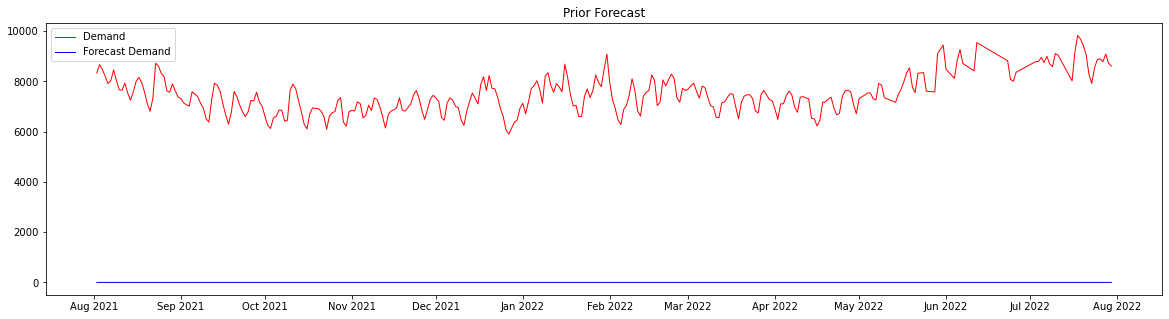

Mean Absolute Error: 7452.14
Root Mean Squared Error: 7489.06
R Squared Score: -521053342.74


In [17]:
fig, ax = plt.subplots(figsize=(20,5))
forecast = ax.plot(Date, Forecast, linewidth=1, color='red')
test = ax.plot(Date, Test, linewidth=1, color='blue')
ax.legend([test, forecast], labels=["Demand", "Forecast Demand"])
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.set_title("Prior Forecast")
plt.show()

# print prior model performance
mae1 = mean_absolute_error(Test, Forecast)
mse1 = mean_squared_error(Test, Forecast)
rmse1 = np.sqrt(mse1)
r21 = r2_score(Test, Forecast)
print("Mean Absolute Error: {:.2f}".format(mae1))
print("Root Mean Squared Error: {:.2f}".format(rmse1))
print("R Squared Score: {:.2f}".format(r21)) 

<ipython-input-18-508e16225dd9>:4: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend([test, forecast], labels=["Demand", "Forecast Demand"])


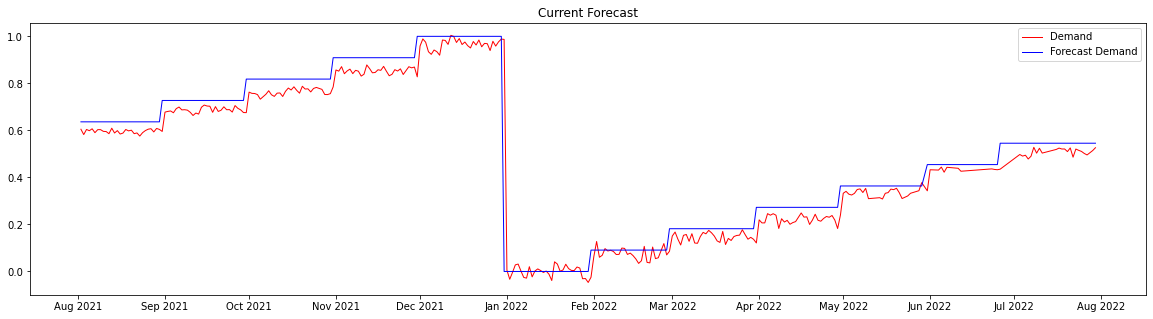

Mean Absolute Error: 0.04
Root Mean Squared Error: 0.07
R Squared Score: 0.95


In [18]:
fig, ax = plt.subplots(figsize=(20,5)) 
forecast = ax.plot(Date, Pred, linewidth=1, color='red')
test = ax.plot(Date, Test, linewidth=1, color='blue')
ax.legend([test, forecast], labels=["Demand", "Forecast Demand"])
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.set_title("Current Forecast")
plt.show()

# print current model performance
mae2 = mean_absolute_error(Test, Pred)
mse2 = mean_squared_error(Test, Pred)
rmse2 = np.sqrt(mse2)
r22 = r2_score(Test, Pred)
print("Mean Absolute Error: {:.2f}".format(mae2))
print("Root Mean Squared Error: {:.2f}".format(rmse2))
print("R Squared Score: {:.2f}".format(r22)) 

# SHAP

In [19]:
import shap

In [ ]:
# # combat shap.DeepExplainer issue (did not work)
# import tensorflow as tf    
# tf.compat.v1.disable_v2_behavior()

In [20]:
# explain the model's predictions using SHAP values

# Please note, error when running shap_values = explainer.shap_values(X_test)
# error: 'TFDeep' object has no attribute 'between_tensors'

explainer = shap.DeepExplainer(model, X_train)
shap_values = explainer.shap_values(X_test)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


AttributeError: in user code:

    File "C:\Users\c-b-2\anaconda3\lib\site-packages\shap\explainers\_deep\deep_tf.py", line 247, in grad_graph  *
        out = self.model(shap_rAnD)
    File "C:\Users\c-b-2\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\c-b-2\anaconda3\lib\site-packages\shap\explainers\_deep\deep_tf.py", line 378, in custom_grad
        out = op_handlers[type_name](self, op, *grads) # we cut off the shap_ prefex before the lookup
    File "C:\Users\c-b-2\anaconda3\lib\site-packages\shap\explainers\_deep\deep_tf.py", line 667, in handler
        return linearity_with_excluded_handler(input_inds, explainer, op, *grads)
    File "C:\Users\c-b-2\anaconda3\lib\site-packages\shap\explainers\_deep\deep_tf.py", line 674, in linearity_with_excluded_handler
        assert not explainer._variable_inputs(op)[i], str(i) + "th input to " + op.name + " cannot vary!"
    File "C:\Users\c-b-2\anaconda3\lib\site-packages\shap\explainers\_deep\deep_tf.py", line 224, in _variable_inputs
        out[i] = t.name in self.between_tensors

    AttributeError: Exception encountered when calling layer 'lstm_1' (type LSTM).
    
    'TFDeep' object has no attribute 'between_tensors'
    
    Call arguments received by layer 'lstm_1' (type LSTM):
      • inputs=tf.Tensor(shape=(2832, 1, 128), dtype=float32)
      • mask=None
      • training=False
      • initial_state=None


In [ ]:
# visualise the first prediction's explanation
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

In [ ]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X_train)

In [ ]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

In [ ]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

### Supporting resources
shap.DeepExplainer
https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html

SHAP - Neural networks - Census income classification with Keras
https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/neural_networks/Census%20income%20classification%20with%20Keras.html

SHAP - Keras LSTM for IMDB Sentiment Classification
https://shap.readthedocs.io/en/latest/example_notebooks/text_examples/sentiment_analysis/Keras%20LSTM%20for%20IMDB%20Sentiment%20Classification.html

Kaggle - SHAP for LSTM
https://www.kaggle.com/code/phamvanvung/shap-for-lstm/notebook

[forecast][LSTM+SHAP]Applied SHAP on the polynomial equation case with LSTM algorithm
https://medium.com/@sakamoto2000.kim/applied-shap-on-the-polynomial-equation-case-with-lstm-algorithm-7c140d15736b

#### Troubleshooting error when running "shap_values = explainer.shap_values(X_test)", error: 'TFDeep' object has no attribute 'between_tensors'
https://github.com/slundberg/shap/issues/2808

https://www.pythonfixing.com/2021/12/fixed-shap-deepexplainer-with.html

https://stackoverflow.com/questions/66814523/shap-deepexplainer-with-tensorflow-2-4-error